In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.utils import testing
from tyssue.io import hdf5

from tyssue_taylor.adjusters.adjust_annular import _prepare_tensions, adjust_tensions
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model

Reseting datasets values with new specs


(<matplotlib.figure.Figure at 0x7f161ff24550>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f16162402e8>)

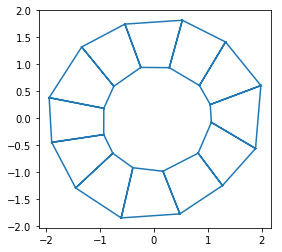

In [2]:
Nf = 12
R_in = 1
R_out = 2

organo = generate_ring(Nf, R_in, R_out)

geom.update_all(organo)
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area': organo.face_df.area.mean()*0.9,
        'area_elasticity': 1,},
    'edge':{
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.01,
        'is_active': 1
        },
    'vert':{
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 1.,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }
organo.update_specs(specs, reset=True)

#Initializing the organo with random parameters

tension_noise = np.random.normal(1, 0.1, size=3*Nf).clip(min=0)
area_noise = np.random.normal(1, 0.05, size=Nf).clip(min=0.1)
organo.face_df['prefered_area'] *= area_noise

organo.edge_df.loc[: Nf-1, 'line_tension'] *= 4*tension_noise[: Nf]
organo.edge_df.loc[Nf: 2*Nf-1, 'line_tension'] *= 2*tension_noise[Nf: 2*Nf]

organo.edge_df.loc[2*Nf:3*Nf-1, 'line_tension'] *= tension_noise[2*Nf:]
organo.edge_df.loc[3*Nf: , 'line_tension'] *= tension_noise[2*Nf:]

res = Solver.find_energy_min(organo, geom, model,
                             minimize={'options': {'gtol': 1e-7, 'ftol': 1e-6}})

quick_edge_draw(organo)


In [3]:
start = time.clock()

noisy = organo.copy()

print("Organo's coordinates are different from copy's coordinates : ", bool(not np.prod(
        np.prod(np.equal(organo.vert_df.loc[:, ('x','y')],noisy.vert_df.loc[:, ('x','y')])))))


initial_guess = organo.edge_df.line_tension[: 3*Nf]

res = adjust_tensions(noisy, initial_guess, {'options': {'gtol': 1e-7, 'ftol': 1e-6}}, \
                      **{'method': 'L-BFGS-B','options': {'gtol': 1e-4, 'ftol': 1e-4,'eps': 1e-15}})

elapsed = time.clock() - start
dif = np.abs(organo.edge_df.line_tension-_prepare_tensions(noisy,res.x))
#copy_res.append(('copy',np.mean(dif),np.count_nonzero(dif),np.max(dif),elapsed))

print(f'Mean gap : {np.mean(dif)}\nNumber of non zero gap : {np.count_nonzero(dif)}\nMax gap : {np.max(dif)}\
      \nSolving time : {elapsed}\nObjective value : {res.fun}\nNb iter : {res.nit}')


Organo's coordinates are different from copy's coordinates :  False
Mean gap : 0.00017754511698773925
Number of non zero gap : 12
Max gap : 0.0015480507838665641      
Solving time : 204.079404
Objective value : 0.00452434526324922
 Nb iter : 0


In [4]:
copy_res = res

Organo's coordinates are different from copy's coordinates :  True
Mean gap : 0.000642270013536002
Number of non zero gap : 48
Max gap : 0.002164264311676215      
Solving time : 554.837155
Objective value : 0.012637738285048942
Nb iter : 6


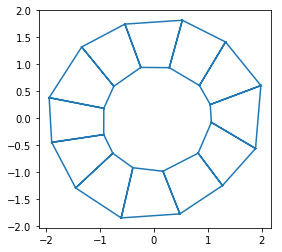

In [5]:
start = time.clock()

noisy = organo.copy()

#Moving the organo's copy coordinates
v = np.random.randint(0,2*Nf)
coordinate_noise = np.random.normal(1, 0.02)
#coordinates_noise = np.random.normal(1, 0.02, size=(2*Nf,2)).clip(min=0)
noisy.vert_df.loc[[v], ('x','y')] *= coordinate_noise


#Verifying that the copy has moved wrt the organo

print("Organo's coordinates are different from copy's coordinates : ", bool(not np.prod(
        np.prod(np.equal(organo.vert_df.loc[:, ('x','y')],noisy.vert_df.loc[:, ('x','y')])))))

#start = time.clock()
initial_guess = organo.edge_df.line_tension[: 3*Nf]

res = adjust_tensions(noisy, initial_guess, {'options': {'gtol': 1e-4, 'ftol': 1e-4}}, \
                      **{'method': 'L-BFGS-B','options': {'gtol': 1e-4, 'ftol': 1e-4}})

very_sligh_res = res
elapsed = time.clock() - start
dif = np.abs(organo.edge_df.line_tension-_prepare_tensions(noisy,res.x))
#copy_res.append(('copy',np.mean(dif),np.count_nonzero(dif),np.max(dif),elapsed))

print(f'Mean gap : {np.mean(dif)}\nNumber of non zero gap : {np.count_nonzero(dif)}\nMax gap : {np.max(dif)}\
      \nSolving time : {elapsed}\nObjective value : {res.fun}\nNb iter : {res.nit}')
    

(<matplotlib.figure.Figure at 0x7f1612700ef0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f161288d630>)

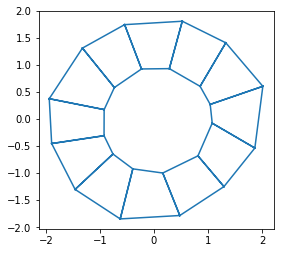

In [10]:
noisy.edge_df.line_tension = _prepare_tensions(noisy,very_sligh_res.x)
res = Solver.find_energy_min(noisy, geom, model,
                             minimize={'options': {'gtol': 1e-7, 'ftol': 1e-6}})

quick_edge_draw(noisy)

Organo's coordinates are different from copy's coordinates :  True
Mean gap : 0.002722453604232062
Number of non zero gap : 48
Max gap : 0.006950183750031319      
Solving time : 1078.1418949999997
Objective value : 0.011378695714289377
Nb iter : 8


(<matplotlib.figure.Figure at 0x7f16126afbe0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1612890630>)

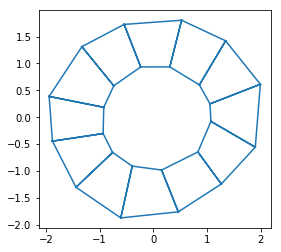

In [11]:
start = time.clock()

noisy = organo.copy()

#Moving the organo's copy coordinates
v = np.random.randint(0,2*Nf,int(np.ceil(Nf*0.2)))
coordinate_noise = np.random.normal(1, 0.01, (len(v),2))
#coordinates_noise = np.random.normal(1, 0.02, size=(2*Nf,2)).clip(min=0)
noisy.vert_df.loc[v, ('x','y')] *= coordinate_noise


#Verifying that the copy has moved wrt the organo

print("Organo's coordinates are different from copy's coordinates : ", bool(not np.prod(
        np.prod(np.equal(organo.vert_df.loc[:, ('x','y')],noisy.vert_df.loc[:, ('x','y')])))))

#start = time.clock()
initial_guess = organo.edge_df.line_tension[: 3*Nf]

res = adjust_tensions(noisy, initial_guess, {'options': {'gtol': 1e-4, 'ftol': 1e-4}}, \
                      **{'method': 'L-BFGS-B','options': {'gtol': 1e-4, 'ftol': 1e-4}})

sligh_res = res
elapsed = time.clock() - start
dif = np.abs(organo.edge_df.line_tension-_prepare_tensions(noisy,res.x))
#copy_res.append(('copy',np.mean(dif),np.count_nonzero(dif),np.max(dif),elapsed))

print(f'Mean gap : {np.mean(dif)}\nNumber of non zero gap : {np.count_nonzero(dif)}\nMax gap : {np.max(dif)}\
      \nSolving time : {elapsed}\nObjective value : {res.fun}\nNb iter : {res.nit}')

noisy.edge_df.line_tension = _prepare_tensions(noisy,sligh_res.x)
res = Solver.find_energy_min(noisy, geom, model,
                             minimize={'options': {'gtol': 1e-7, 'ftol': 1e-6}})

quick_edge_draw(noisy)

Organo's coordinates are different from copy's coordinates :  True
Mean gap : 0.0014621015823537158
Number of non zero gap : 48
Max gap : 0.006091100122767029      
Solving time : 1943.2013849999998
Objective value : 0.07364814847140064
Nb iter : 3


(<matplotlib.figure.Figure at 0x7f1612547d30>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f16128adc88>)

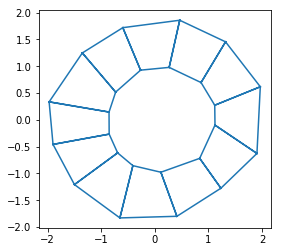

In [14]:
start = time.clock()

noisy = organo.copy()

#Moving the organo's copy coordinates
coordinate_noise = np.random.normal(1, 0.01, (2*Nf,2))
#coordinates_noise = np.random.normal(1, 0.02, size=(2*Nf,2)).clip(min=0)
noisy.vert_df.loc[:, ('x','y')] *= coordinate_noise


#Verifying that the copy has moved wrt the organo

print("Organo's coordinates are different from copy's coordinates : ", bool(not np.prod(
        np.prod(np.equal(organo.vert_df.loc[:, ('x','y')],noisy.vert_df.loc[:, ('x','y')])))))

#start = time.clock()
initial_guess = organo.edge_df.line_tension[: 3*Nf]

res = adjust_tensions(noisy, initial_guess, {'options': {'gtol': 1e-4, 'ftol': 1e-4}}, \
                      **{'method': 'L-BFGS-B','options': {'gtol': 1e-4, 'ftol': 1e-4}})

substantial_res = res
elapsed = time.clock() - start
dif = np.abs(organo.edge_df.line_tension-_prepare_tensions(noisy,res.x))
#copy_res.append(('copy',np.mean(dif),np.count_nonzero(dif),np.max(dif),elapsed))

print(f'Mean gap : {np.mean(dif)}\nNumber of non zero gap : {np.count_nonzero(dif)}\nMax gap : {np.max(dif)}\
      \nSolving time : {elapsed}\nObjective value : {res.fun}\nNb iter : {res.nit}')

noisy.edge_df.line_tension = _prepare_tensions(noisy,substantial_res.x)
res = Solver.find_energy_min(noisy, geom, model,
                             minimize={'options': {'gtol': 1e-7, 'ftol': 1e-6}})

quick_edge_draw(noisy)

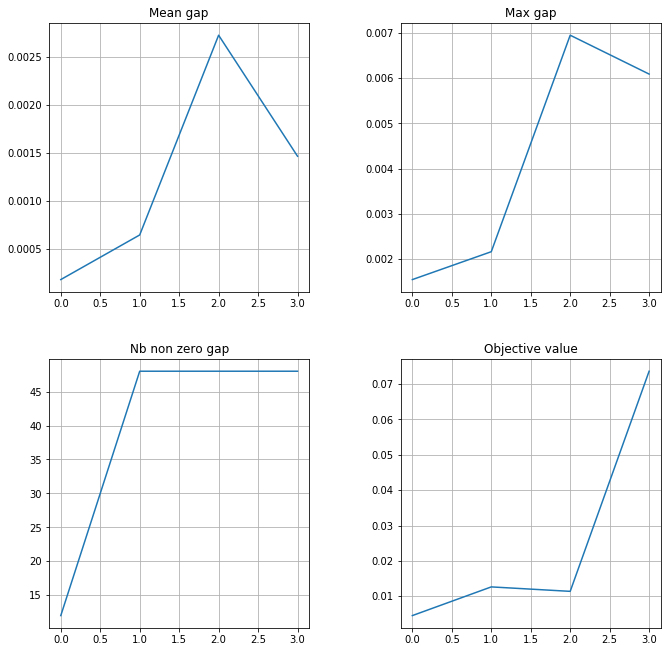

In [28]:
dif_copy = np.abs(organo.edge_df.line_tension-_prepare_tensions(noisy,copy_res.x))
dif_vs = np.abs(organo.edge_df.line_tension-_prepare_tensions(noisy,very_sligh_res.x))
dif_sligh = np.abs(organo.edge_df.line_tension-_prepare_tensions(noisy,sligh_res.x))
dif_sub = dif
# plot with various axes scales
plt.figure(1)
plt.figure(figsize=(10,10))
# Mean gap
plt.subplot(221)
plt.plot([np.mean(dif_copy),np.mean(dif_vs),np.mean(dif_sligh),np.mean(dif_sub)])
plt.title('Mean gap')
plt.grid(True)


# Max gap
plt.subplot(222)
plt.plot([np.max(dif_copy),np.max(dif_vs),np.max(dif_sligh),np.max(dif_sub)])
plt.title('Max gap')
plt.grid(True)


# Number of non zero gap
plt.subplot(223)
plt.plot([np.count_nonzero(dif_copy),np.count_nonzero(dif_vs),np.count_nonzero(dif_sligh),np.count_nonzero(dif_sub)])
plt.title('Nb non zero gap')
plt.grid(True)

# Objective value
plt.subplot(224)
plt.plot([copy_res.fun,very_sligh_res.fun,sligh_res.fun,substantial_res.fun])
plt.title('Objective value')
plt.grid(True)
# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.show()